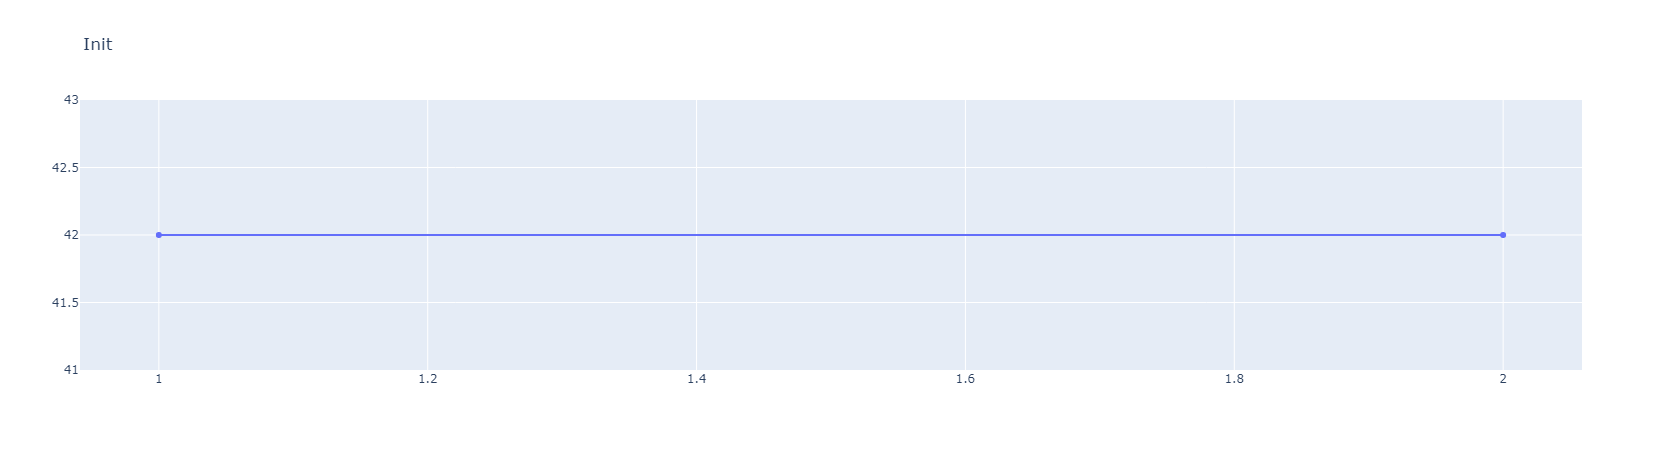

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.clustering import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.stat import Correlation
from pyspark.ml.functions import vector_to_array

# iplot won't work because I've not installed the extension
import chart_studio.plotly as ply
import plotly.offline as plyoff
import plotly.graph_objects as go
import plotly.subplots as plysub

plyoff.init_notebook_mode(connected=True)
init = go.Figure(data=[go.Scatter(x=[1,2], y=[42,42])], layout=go.Layout(title='Init'))
plyoff.iplot(init)

pd.set_option('display.max_columns', None)

In [2]:
# initialize
sc = pyspark.SparkContext()
spark = SparkSession(sc)
spark.sparkContext.appName = 'gmm'
# show the number of cores
print('%d cores'%spark._jsc.sc().getExecutorMemoryStatus().keySet().size())
spark

1 cores


In [3]:
''' get the data '''
# load the data - can't parse the timestamp for some reason, so just let it be string
fil = '../data/sales_data_sample.csv'
schem = StructType([StructField('ORDERNUMBER', IntegerType()), StructField('QUANTITYORDERED', IntegerType()),
                    StructField('PRICEEACH', FloatType()), StructField('ORDERLINENUMBER', IntegerType()),
                    StructField('SALES', FloatType()), StructField('ORDERDATE', StringType()),# TimestampType()),
                    StructField('STATUS', StringType()), StructField('QTR_ID', IntegerType()),
                    StructField('MONTH_ID', IntegerType()), StructField('YEAR_ID', IntegerType()),
                    StructField('PRODUCTLINE', StringType()), StructField('MSRP', FloatType()),
                    StructField('PRODUCTCODE', StringType()), StructField('CUSTOMERNAME', StringType()),
                    StructField('PHONE', IntegerType()), StructField('ADDRESSLINE1', StringType()),
                    StructField('ADDRESSLINE2', StringType()), StructField('CITY', StringType()),
                    StructField('STATE', StringType()), StructField('POSTALCODE', StringType()),
                    StructField('COUNTRY', StringType()), StructField('TERRITORY', StringType()),
                    StructField('CONTACTLASTNAME', FloatType()), StructField('CONTACTFIRSTNAME', StringType()),
                    StructField('DEALSIZE', StringType())])
sales = spark.read.format('csv').options(header=True, timestampFormat='M/d/yyyy HH:MM').schema(schem).load(fil)

# talk
cnt = sales.count()
print('%d records'%cnt)
sales.show(truncate=False)

2823 records
+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+--------------------------+----------+-----------------------------+------------+-------------+--------+----------+---------+---------+---------------+----------------+--------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|SALES  |ORDERDATE      |STATUS |QTR_ID|MONTH_ID|YEAR_ID|PRODUCTLINE|MSRP|PRODUCTCODE|CUSTOMERNAME              |PHONE     |ADDRESSLINE1                 |ADDRESSLINE2|CITY         |STATE   |POSTALCODE|COUNTRY  |TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|
+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+--------------------------+----------+-----------------------------+------------+-------------+--------+----------+---------+---------+---------------+----------------+--------+
|10107      |30             |95.7

In [4]:
# check out an order
display(sales.where(col('ORDERNUMBER')==10159).orderBy(col('ORDERLINENUMBER')).toPandas())

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10159,50,69.800003,1,3490.000000,10/10/2003 0:00,Shipped,4,10,2003,Classic Cars,61.0,S24_3371,Corporate Gift Ideas Co.,NaN,7734 Strong St.,None,San Francisco,CA,None,USA,NA,NaN,Julie,Medium
1,10159,41,100.000000,2,8296.349609,10/10/2003 0:00,Shipped,4,10,2003,Classic Cars,194.0,S12_1099,Corporate Gift Ideas Co.,NaN,7734 Strong St.,None,San Francisco,CA,None,USA,NA,NaN,Julie,Large
2,10159,24,73.419998,3,1762.079956,10/10/2003 0:00,Shipped,4,10,2003,Classic Cars,79.0,S12_3990,Corporate Gift Ideas Co.,NaN,7734 Strong St.,None,San Francisco,CA,None,USA,NA,NaN,Julie,Small
3,10159,25,100.000000,4,3638.000000,10/10/2003 0:00,Shipped,4,10,2003,Classic Cars,146.0,S18_3482,Corporate Gift Ideas Co.,NaN,7734 Strong St.,None,San Francisco,CA,None,USA,NA,NaN,Julie,Medium
4,10159,21,81.209999,5,1705.410034,10/10/2003 0:00,Shipped,4,10,2003,Classic Cars,80.0,S18_3278,Corporate Gift Ideas Co.,NaN,7734 Strong St.,None,San Francisco,CA,None,USA,NA,NaN,Julie,Small
5,10159,23,67.099998,6,1543.300049,10/10/2003 0:00,Shipped,4,10,2003,Classic Cars,80.0,S24_4620,Corporate Gift Ideas Co.,NaN,7734 Strong St.,None,San Francisco,CA,None,USA,NA,NaN,Julie,Small
6,10159,32,100.000000,7,4618.879883,10/10/2003 0:00,Shipped,4,10,2003,Classic Cars,148.0,S18_4721,Corporate Gift Ideas Co.,NaN,7734 Strong St.,None,San Francisco,CA,None,USA,NA,NaN,Julie,Medium
7,10159,21,64.660004,8,1357.859985,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,62.0,S18_3782,Corporate Gift Ideas Co.,NaN,7734 Strong St.,None,San Francisco,CA,None,USA,NA,NaN,Julie,Small
8,10159,35,35.400002,9,1239.000000,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,40.0,S32_2206,Corporate Gift Ideas Co.,NaN,7734 Strong St.,None,San Francisco,CA,None,USA,NA,NaN,Julie,Small
9,10159,31,71.599998,10,2219.600098,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,81.0,S50_4713,Corporate Gift Ideas Co.,NaN,7734 Strong St.,None,San Francisco,CA,None,USA,NA,NaN,Julie,Small


### Data Prep

In [5]:
# drop some columns that I have no doubt will not be useful for modeling - the latter because I can't aggregate them
# dropping quarter as it's highly correlated with month
sales = sales.drop('CONTACTLASTNAME', 'ADDRESSLINE2', 'CUSTOMERNAME', 'CONTACTFIRSTNAME', 'ADDRESSLINE1',
                   'ORDERDATE', 'PRODUCTLINE', 'PRODUCTCODE', 'QTR_ID')

In [6]:
''' handle missing values '''
# presumably important columns (for modeling)
importantCols = ['STATE', 'POSTALCODE', 'ORDERNUMBER', 'TERRITORY', 'COUNTRY',
                 'CITY', 'QUANTITYORDERED', 'MSRP', 'YEAR_ID', 'MONTH_ID',
                 'STATUS', 'SALES', 'ORDERLINENUMBER', 'PRICEEACH',
                 'DEALSIZE']

# check for missing values
nullCounts = {colm:sales.select(colm).where(col(colm).isNull()).count() for colm in sales.columns}
nullCounts = {colm:(ncnt, ncnt/cnt) for (colm, ncnt) in nullCounts.items()}
nullCountsDF = pd.DataFrame(nullCounts).T.reset_index(drop=False).sort_values(1, ascending=False)
nullCountsDF.columns = ['Column', 'Freq.', 'Rel. Freq.']
nullCountsDF = nullCountsDF.merge(pd.DataFrame([[colm.name, colm.dataType] for colm in sales.schema], columns=['Column', 'Type']),
                                how='inner', on=['Column'])
nullCountsDF['Important'] = [c in importantCols for c in nullCountsDF['Column']]

# talk
display(nullCountsDF)

# fill null states with 'NA' as they are ex-US, and the missing zip codes for california to the range
sales = sales.fillna(value='NA', subset='STATE').fillna(value='90001_96162', subset='POSTALCODE')

# talk some more
print('%d records'%sales.count())
display(sales.limit(10).toPandas())

,Column,Freq.,Rel. Freq.,Type,Important
0,PHONE,2589.0,0.917109,IntegerType,False
1,STATE,1486.0,0.526390,StringType,True
2,POSTALCODE,76.0,0.026922,StringType,True
3,ORDERNUMBER,0.0,0.000000,IntegerType,True
4,QUANTITYORDERED,0.0,0.000000,IntegerType,True
5,PRICEEACH,0.0,0.000000,FloatType,True
6,ORDERLINENUMBER,0.0,0.000000,IntegerType,True
7,SALES,0.0,0.000000,FloatType,True
8,STATUS,0.0,0.000000,StringType,True
9,MONTH_ID,0.0,0.000000,IntegerType,True


2823 records


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,STATUS,MONTH_ID,YEAR_ID,MSRP,PHONE,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,DEALSIZE
0,10107,30,95.699997,2,2871.000000,Shipped,2,2003,95.0,2.125558e+09,NYC,NY,10022,USA,NA,Small
1,10121,34,81.349998,5,2765.899902,Shipped,5,2003,95.0,NaN,Reims,NA,51100,France,EMEA,Small
2,10134,41,94.739998,2,3884.340088,Shipped,7,2003,95.0,NaN,Paris,NA,75508,France,EMEA,Medium
3,10145,45,83.260002,6,3746.699951,Shipped,8,2003,95.0,NaN,Pasadena,CA,90003,USA,NA,Medium
4,10159,49,100.000000,14,5205.270020,Shipped,10,2003,95.0,NaN,San Francisco,CA,90001_96162,USA,NA,Medium
5,10168,36,96.660004,1,3479.760010,Shipped,10,2003,95.0,NaN,Burlingame,CA,94217,USA,NA,Medium
6,10180,29,86.129997,9,2497.770020,Shipped,11,2003,95.0,NaN,Lille,NA,59000,France,EMEA,Small
7,10188,48,100.000000,1,5512.319824,Shipped,11,2003,95.0,NaN,Bergen,NA,N 5804,Norway,EMEA,Medium
8,10201,22,98.570000,2,2168.540039,Shipped,12,2003,95.0,NaN,San Francisco,CA,90001_96162,USA,NA,Small
9,10211,41,100.000000,14,4708.439941,Shipped,1,2004,95.0,NaN,Paris,NA,75016,France,EMEA,Medium


In [7]:
''' see some value counts '''
for colm in ['STATUS', 'STATE', 'POSTALCODE', 'COUNTRY', 'TERRITORY', 'DEALSIZE']:
    print(colm)
    sales.select(colm).groupBy(colm).count().show()

STATUS
+----------+-----+
|    STATUS|count|
+----------+-----+
|   Shipped| 2617|
|   On Hold|   44|
| Cancelled|   60|
|  Resolved|   47|
|In Process|   41|
|  Disputed|   14|
+----------+-----+

STATE
+-------------+-----+
|        STATE|count|
+-------------+-----+
|           NJ|   21|
|           NA| 1486|
|     Victoria|   78|
|           BC|   48|
|           NH|   34|
|           NV|   29|
|        Tokyo|   32|
|           CA|  416|
|           CT|   61|
|           PA|   75|
|           NY|  178|
|       Quebec|   22|
|Isle of Wight|   26|
|        Osaka|   20|
|           MA|  190|
|   Queensland|   15|
|          NSW|   92|
+-------------+-----+

POSTALCODE
+----------+-----+
|POSTALCODE|count|
+----------+-----+
|     28034|  259|
|   WX1 6LT|   29|
|     97823|   17|
|     51003|   44|
|     97562|  205|
|     67000|   19|
|    B-6000|    8|
|     92561|    3|
|     80686|   14|
|     41101|   15|
|      8200|   27|
|  530-0003|   20|
|     44000|   60|
|     69045|   36|

In [8]:
''' index the string columns '''
# set the string columns to index
strCols = ['STATUS', 'STATE', 'POSTALCODE', 'COUNTRY', 'TERRITORY', 'DEALSIZE']
# do the indexing
indxr = StringIndexer(inputCols=strCols, outputCols=[c+'_int' for c in strCols])
sales = indxr.fit(sales).transform(sales)
# talk
display(sales.limit(10).toPandas())

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,STATUS,MONTH_ID,YEAR_ID,MSRP,PHONE,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,DEALSIZE,STATUS_int,POSTALCODE_int,TERRITORY_int,STATE_int,COUNTRY_int,DEALSIZE_int
0,10107,30,95.699997,2,2871.000000,Shipped,2,2003,95.0,2.125558e+09,NYC,NY,10022,USA,NA,Small,0.0,2.0,1.0,3.0,0.0,1.0
1,10121,34,81.349998,5,2765.899902,Shipped,5,2003,95.0,NaN,Reims,NA,51100,France,EMEA,Small,0.0,17.0,0.0,0.0,2.0,1.0
2,10134,41,94.739998,2,3884.340088,Shipped,7,2003,95.0,NaN,Paris,NA,75508,France,EMEA,Medium,0.0,60.0,0.0,0.0,2.0,0.0
3,10145,45,83.260002,6,3746.699951,Shipped,8,2003,95.0,NaN,Pasadena,CA,90003,USA,NA,Medium,0.0,33.0,1.0,1.0,0.0,0.0
4,10159,49,100.000000,14,5205.270020,Shipped,10,2003,95.0,NaN,San Francisco,CA,90001_96162,USA,NA,Medium,0.0,4.0,1.0,1.0,0.0,0.0
5,10168,36,96.660004,1,3479.760010,Shipped,10,2003,95.0,NaN,Burlingame,CA,94217,USA,NA,Medium,0.0,3.0,1.0,1.0,0.0,0.0
6,10180,29,86.129997,9,2497.770020,Shipped,11,2003,95.0,NaN,Lille,NA,59000,France,EMEA,Small,0.0,59.0,0.0,0.0,2.0,1.0
7,10188,48,100.000000,1,5512.319824,Shipped,11,2003,95.0,NaN,Bergen,NA,N 5804,Norway,EMEA,Medium,0.0,36.0,0.0,0.0,7.0,0.0
8,10201,22,98.570000,2,2168.540039,Shipped,12,2003,95.0,NaN,San Francisco,CA,90001_96162,USA,NA,Small,0.0,4.0,1.0,1.0,0.0,1.0
9,10211,41,100.000000,14,4708.439941,Shipped,1,2004,95.0,NaN,Paris,NA,75016,France,EMEA,Medium,0.0,38.0,0.0,0.0,2.0,0.0


In [9]:
''' aggregate by order '''
# set the output features
features = ['AvgQuantity', 'AvgPrice', 'LineCount', 'Month', 'Year', 'AvgMSRP', 'Status', 'State', 'Country',
            'PostCode', 'DealSize', 'Territory', 'TotalSale', 'ItemCount']
# agg
sales = sales.groupBy('ORDERNUMBER').agg(mean('QUANTITYORDERED').alias('AvgQuantity'), mean('PRICEEACH').alias('AvgPrice'),
                                         max('ORDERLINENUMBER').alias('LineCount'), min('MONTH_ID').alias('Month'),
                                         min('YEAR_ID').alias('Year'), mean('MSRP').alias('AvgMSRP'),
                                         min('STATUS_int').alias('Status'), min('STATE_int').alias('State'),
                                         min('COUNTRY_int').alias('Country'), min('POSTALCODE_int').alias('PostCode'),
                                         min('DEALSIZE_int').alias('DealSize'), min('TERRITORY_int').alias('Territory'),
                                         sum('SALES').alias('TotalSale'), sum('QUANTITYORDERED').alias('ItemCount'))\
    .select('ORDERNUMBER', *features)
# talk
display(sales.limit(10).toPandas())

,ORDERNUMBER,AvgQuantity,AvgPrice,LineCount,Month,Year,AvgMSRP,Status,State,Country,PostCode,DealSize,Territory,TotalSale,ItemCount
0,10206,32.272727,86.770000,11,12,2003,104.000000,0.0,8.0,9.0,56.0,0.0,1.0,38662.209717,355
1,10362,29.250000,86.647499,4,1,2005,128.750000,0.0,1.0,0.0,3.0,0.0,1.0,13529.570190,117
2,10121,37.000000,83.963998,5,5,2003,99.400000,0.0,0.0,2.0,17.0,0.0,0.0,18971.959717,185
3,10230,42.250000,83.421250,8,3,2004,108.375000,0.0,0.0,11.0,54.0,0.0,0.0,37266.489380,338
4,10395,39.000000,92.280001,4,3,2005,129.000000,0.0,0.0,2.0,60.0,0.0,0.0,20321.529785,156
5,10416,32.857143,82.759285,14,5,2005,88.428571,0.0,0.0,5.0,20.0,0.0,0.0,41509.940063,460
6,10257,41.600000,78.972000,5,6,2004,92.600000,0.0,1.0,0.0,3.0,0.0,1.0,16128.100098,208
7,10264,36.142857,74.734285,7,6,2004,83.142857,0.0,2.0,0.0,14.0,0.0,1.0,19548.350037,253
8,10128,39.250000,97.290001,4,6,2003,102.250000,0.0,0.0,1.0,0.0,0.0,0.0,17448.080078,157
9,10183,32.583333,87.916666,12,11,2003,109.416667,0.0,6.0,0.0,15.0,0.0,1.0,40061.660034,391


In [10]:
''' prepare the features '''
# create the features vector - no need to scale
assr = VectorAssembler(inputCols=features, outputCol='features')
sales = assr.transform(sales)

# talk
display(sales.limit(10).toPandas())
sales.select('features').take(1)
print('First row features = %s'%sales.select('features').take(1)[0])

,ORDERNUMBER,AvgQuantity,AvgPrice,LineCount,Month,Year,AvgMSRP,Status,State,Country,PostCode,DealSize,Territory,TotalSale,ItemCount,features
0,10206,32.272727,86.770000,11,12,2003,104.000000,0.0,8.0,9.0,56.0,0.0,1.0,38662.209717,355,"[32.27272727272727, 86.77000011097302, 11.0, 1..."
1,10362,29.250000,86.647499,4,1,2005,128.750000,0.0,1.0,0.0,3.0,0.0,1.0,13529.570190,117,"[29.25, 86.64749908447266, 4.0, 1.0, 2005.0, 1..."
2,10121,37.000000,83.963998,5,5,2003,99.400000,0.0,0.0,2.0,17.0,0.0,0.0,18971.959717,185,"[37.0, 83.96399841308593, 5.0, 5.0, 2003.0, 99..."
3,10230,42.250000,83.421250,8,3,2004,108.375000,0.0,0.0,11.0,54.0,0.0,0.0,37266.489380,338,"[42.25, 83.42125034332275, 8.0, 3.0, 2004.0, 1..."
4,10395,39.000000,92.280001,4,3,2005,129.000000,0.0,0.0,2.0,60.0,0.0,0.0,20321.529785,156,"[39.0, 92.28000068664551, 4.0, 3.0, 2005.0, 12..."
5,10416,32.857143,82.759285,14,5,2005,88.428571,0.0,0.0,5.0,20.0,0.0,0.0,41509.940063,460,"[32.857142857142854, 82.75928470066616, 14.0, ..."
6,10257,41.600000,78.972000,5,6,2004,92.600000,0.0,1.0,0.0,3.0,0.0,1.0,16128.100098,208,"[41.6, 78.97200012207031, 5.0, 6.0, 2004.0, 92..."
7,10264,36.142857,74.734285,7,6,2004,83.142857,0.0,2.0,0.0,14.0,0.0,1.0,19548.350037,253,"[36.142857142857146, 74.73428508213588, 7.0, 6..."
8,10128,39.250000,97.290001,4,6,2003,102.250000,0.0,0.0,1.0,0.0,0.0,0.0,17448.080078,157,"[39.25, 97.29000091552734, 4.0, 6.0, 2003.0, 1..."
9,10183,32.583333,87.916666,12,11,2003,109.416667,0.0,6.0,0.0,15.0,0.0,1.0,40061.660034,391,"[32.583333333333336, 87.91666634877522, 12.0, ..."


First row features = [32.27272727272727,86.77000011097302,11.0,12.0,2003.0,104.0,0.0,8.0,9.0,56.0,0.0,1.0,38662.209716796875,355.0]


In [11]:
# check for multicollinearity
corr = Correlation.corr(sales, column='features', method='pearson')
corrdf = pd.DataFrame(index=features, data=corr.collect()[0][0].toArray(), columns=features)
display(corrdf)

,AvgQuantity,AvgPrice,LineCount,Month,Year,AvgMSRP,Status,State,Country,PostCode,DealSize,Territory,TotalSale,ItemCount
AvgQuantity,1.000000,0.062665,-0.116250,-0.088645,0.184497,0.082597,0.183027,-0.058360,-0.155987,-0.071344,-0.017657,-0.049534,0.043590,0.030248
AvgPrice,0.062665,1.000000,0.031989,-0.008084,-0.047240,0.782062,-0.000776,0.020867,0.083265,0.068795,-0.380235,0.022937,0.161578,0.037275
LineCount,-0.116250,0.031989,1.000000,0.118641,-0.098433,0.033879,-0.046119,-0.032483,-0.035080,-0.196875,-0.327106,-0.019801,0.947835,0.982735
Month,-0.088645,-0.008084,0.118641,1.000000,-0.441549,-0.030964,-0.099557,0.002020,-0.004976,0.057231,-0.032925,-0.032708,0.110859,0.099039
Year,0.184497,-0.047240,-0.098433,-0.441549,1.000000,-0.038607,0.318256,0.014285,-0.001681,-0.085471,0.064561,0.013328,-0.066069,-0.063980
AvgMSRP,0.082597,0.782062,0.033879,-0.030964,-0.038607,1.000000,0.005358,0.035913,0.089052,0.071918,-0.278742,0.021671,0.216201,0.041080
Status,0.183027,-0.000776,-0.046119,-0.099557,0.318256,0.005358,1.000000,-0.007418,0.017101,-0.035605,0.176784,-0.021786,-0.019045,-0.008664
State,-0.058360,0.020867,-0.032483,0.002020,0.014285,0.035913,-0.007418,1.000000,-0.060046,0.144013,-0.071679,0.509668,-0.042118,-0.035982
Country,-0.155987,0.083265,-0.035080,-0.004976,-0.001681,0.089052,0.017101,-0.060046,1.000000,0.474515,0.155030,-0.002851,-0.035172,-0.056716
PostCode,-0.071344,0.068795,-0.196875,0.057231,-0.085471,0.071918,-0.035605,0.144013,0.474515,1.000000,0.137353,-0.148703,-0.204198,-0.210889


## Modeling

In [12]:
# split for cross-val
trainPerc = 0.7
randSeed = 42
tran, test = sales.select('ORDERNUMBER', 'features').randomSplit([trainPerc, 1.0 - trainPerc], seed=randSeed)

# talk
print('Training Cases')
tran.select('ORDERNUMBER').show()
print('Testing Cases')
test.select('ORDERNUMBER').show()

Training Cases
+-----------+
|ORDERNUMBER|
+-----------+
|      10206|
|      10362|
|      10230|
|      10395|
|      10257|
|      10128|
|      10143|
|      10183|
|      10366|
|      10195|
|      10293|
|      10303|
|      10162|
|      10241|
|      10290|
|      10371|
|      10180|
|      10345|
|      10414|
|      10186|
+-----------+
only showing top 20 rows

Testing Cases
+-----------+
|ORDERNUMBER|
+-----------+
|      10121|
|      10264|
|      10416|
|      10267|
|      10168|
|      10334|
|      10272|
|      10422|
|      10295|
|      10228|
|      10116|
|      10184|
|      10252|
|      10309|
|      10276|
|      10135|
|      10285|
|      10165|
|      10209|
|      10286|
+-----------+
only showing top 20 rows



In [13]:
''' evaluate different clustering cardinalities '''
# setup range that will be tried
kMax = 6 # make this 1 more than what you actually want
xs = list(range(2, kMax))
kCost = np.ones(kMax)*np.inf
kSil = np.ones(kMax)*-1

# iterate over k
models = [None]*kMax
for k in range(2, kMax):
    print('Trying k = %d'%k)
    # fit the model on the training set
    GMM = GaussianMixture(k=k, seed=randSeed, featuresCol='features')
    models[k] = GMM.fit(tran)
    # eval the model on the training set
    kCost[k] = models[k].summary.logLikelihood
    print('\tLog likelihood = %0.3f'%kCost[k])
    # eval the model on the testing set 
    testPred = models[k].transform(test)
    kSil[k] = ClusteringEvaluator().evaluate(testPred)
    print('\tSilhouette score = %0.3f'%kSil[k])
    
# show the scree plot
fig = plysub.make_subplots(rows=2, cols=1, print_grid=False, subplot_titles=('Train Log Likelihood vs. k', 'Test Silhouette vs. k'))
fig.add_trace(go.Scatter(x=xs, y=kCost[2:], mode='markers+lines'), 1, 1)
fig.add_trace(go.Scatter(x=xs, y=kSil[2:], mode='markers+lines'), 2, 1)
fig['layout']['title'] = '|GMM Results'
plyoff.plot(fig)

# find the min
bestK = np.argmax(kCost)
print('Best model has %d clusters, with a cost of %0.3f'%(bestK, kCost[bestK]))

Trying k = 2
	Log likelihood = -7666.645
	Silhouette score = 0.251
Trying k = 3
	Log likelihood = -7580.097
	Silhouette score = 0.261
Trying k = 4
	Log likelihood = -7518.401
	Silhouette score = -0.064
Trying k = 5
	Log likelihood = -7470.422
	Silhouette score = -0.068
Best model has 0 clusters, with a cost of inf


In [14]:
''' Evaluate best model on test set '''
# get the best
bestK = int(input('Enter the "best" k'))
bestModel = models[bestK]
cst = kCost[bestK]
print('Best GMM model has %d clusters, with a log likelihood of %0.3f'%(bestK, cst))

# predict
testPred = bestModel.transform(test)
# eval
evalSil = ClusteringEvaluator()
silhouette = evalSil.evaluate(testPred)
print('Silhouette score for GMM model with %d cluster = [-1, %0.3f, 1]'%(bestK, silhouette))
# get the centers
cents = pd.DataFrame(index=list(range(bestK)), data=[bestModel.gaussians[k].mean.toArray() for k in list(range(bestK))], columns=features)
display(cents)

Enter the "best" k 5


Best GMM model has 5 clusters, with a log likelihood of -7470.422
Silhouette score for GMM model with 5 cluster = [-1, -0.068, 1]


,AvgQuantity,AvgPrice,LineCount,Month,Year,AvgMSRP,Status,State,Country,PostCode,DealSize,Territory,TotalSale,ItemCount
0,35.52861,83.75861,9.331797,6.953917,2003.852535,101.205731,0.18894,2.115207,3.562212,24.843317,0.036866,0.672811,33139.607246,328.082951
1,35.52861,83.75861,9.331798,6.953918,2003.852535,101.205732,0.18894,2.115207,3.562211,24.843315,0.036866,0.672811,33139.608542,328.082963
2,35.52861,83.75861,9.331797,6.953917,2003.852535,101.205731,0.18894,2.115207,3.562212,24.843319,0.036866,0.672811,33139.606379,328.082944
3,35.52861,83.75861,9.331797,6.953917,2003.852535,101.205731,0.18894,2.115207,3.562212,24.843319,0.036866,0.672811,33139.606414,328.082944
4,35.52861,83.75861,9.331797,6.953917,2003.852535,101.205731,0.18894,2.115207,3.562212,24.843319,0.036866,0.672811,33139.606512,328.082945


In [17]:
''' predict topics on input data '''
# predict and parse the topic probabilities
preds = bestModel.transform(sales).select('ORDERNUMBER', *features, 'prediction', vector_to_array('probability').alias('mixtures')).toPandas()
# label the mixture probabilities and drop the vector column
preds = preds.drop(columns=['mixtures'], inplace=False).join(pd.DataFrame(data=preds['mixtures'].tolist(), columns=['Mixture %d'%k for k in range(bestK)]))
# get the most likely topic
preds['Predicted Mixture'] = preds[['Mixture %d'%k for k in range(bestK)]].idxmax(axis=1)
preds['Predicted Mixture Prob.'] = preds[['Mixture %d'%k for k in range(bestK)]].max(axis=1)
# talk
display(preds.head())

,ORDERNUMBER,AvgQuantity,AvgPrice,LineCount,Month,Year,AvgMSRP,Status,State,Country,PostCode,DealSize,Territory,TotalSale,ItemCount,prediction,Mixture 0,Mixture 1,Mixture 2,Mixture 3,Mixture 4,Predicted Mixture,Predicted Mixture Prob.
0,10206,32.272727,86.770000,11,12,2003,104.000,0.0,8.0,9.0,56.0,0.0,1.0,38662.209717,355,1,0.2,0.2,0.2,0.2,0.2,Mixture 1,0.2
1,10362,29.250000,86.647499,4,1,2005,128.750,0.0,1.0,0.0,3.0,0.0,1.0,13529.570190,117,1,0.2,0.2,0.2,0.2,0.2,Mixture 1,0.2
2,10121,37.000000,83.963998,5,5,2003,99.400,0.0,0.0,2.0,17.0,0.0,0.0,18971.959717,185,1,0.2,0.2,0.2,0.2,0.2,Mixture 1,0.2
3,10230,42.250000,83.421250,8,3,2004,108.375,0.0,0.0,11.0,54.0,0.0,0.0,37266.489380,338,1,0.2,0.2,0.2,0.2,0.2,Mixture 1,0.2
4,10395,39.000000,92.280001,4,3,2005,129.000,0.0,0.0,2.0,60.0,0.0,0.0,20321.529785,156,1,0.2,0.2,0.2,0.2,0.2,Mixture 1,0.2


In [18]:
# characterize the clusters (would want to really use a classification model for this...)
aggs = dict.fromkeys(features, ['min', 'mean', 'max'])
aggs['prediction'] = 'count'
pgb = preds.groupby(by=['prediction']).agg(aggs)
display(pgb.head())

AvgQuantity                         AvgPrice             \
                   min       mean        max        min       mean   
prediction                                                           
0            15.000000  39.162821  67.200000  36.930000  78.197948   
1            26.555556  34.986000  42.875000  64.770000  83.938190   
2            22.000000  35.676485  47.583333  44.625000  81.295708   
3            28.000000  38.850000  53.000000  72.850000  91.523833   
4            36.076923  36.076923  36.076923  74.216154  74.216154   

                       LineCount                Month                Year  \
                   max       min       mean max   min      mean max   min   
prediction                                                                  
0           100.000000         1   3.538462  12     1  4.307692   8  2003   
1           100.000000         2  10.114407  18     1  7.182203  12  2003   
2           100.000000         1   7.659574  18     1  6.276596  11  2003   
3           100.000000         1   1.700000   3     1  5.800000  11  2003   
4            74.216154        13  13.000000  13     1  1.000000   1  2005   

                                 AvgMSRP                         Status  \
                   mean   max        min        mean         max    min   
prediction                                                                
0           2004.384615  2005  40.000000   96.539744  190.000000    0.0   
1           2003.788136  2005  61.666667  100.846500  135.000000    0.0   
2           2003.957447  2005  44.000000   97.824407  150.666667    0.0   
3           2004.100000  2005  79.500000  107.550000  150.000000    0.0   
4           2005.000000  2005  91.538462   91.538462   91.538462    2.0   

                          State                 Country                  \
                mean  max   min      mean   max     min      mean   max   
prediction                                                                
0           1.692308  5.0   0.0  2.615385  14.0     0.0  5.769231  15.0   
1           0.033898  2.0   0.0  1.512712  11.0     0.0  3.173729  18.0   
2           0.659574  4.0   0.0  5.148936  16.0     0.0  5.851064  17.0   
3           0.000000  0.0   0.0  0.800000   5.0     0.0  4.200000  13.0   
4           2.000000  2.0   1.0  1.000000   1.0     0.0  0.000000   0.0   

           PostCode                  DealSize                Territory  \
                min       mean   max      min      mean  max       min   
prediction                                                               
0               0.0  34.153846  72.0      0.0  0.615385  2.0       0.0   
1               0.0  21.750000  72.0      0.0  0.000000  0.0       0.0   
2               0.0  38.595745  73.0      0.0  0.170213  1.0       0.0   
3              10.0  37.900000  71.0      0.0  0.000000  0.0       0.0   
4              33.0  33.000000  33.0      0.0  0.000000  0.0       1.0   

                              TotalSale                             ItemCount  \
                mean  max           min          mean           max       min   
prediction                                                                      
0           0.615385  3.0    553.950012  15491.429279  46518.999512        15   
1           0.542373  2.0   4749.449951  35826.619732  68943.400513        62   
2           1.276596  3.0   1474.660034  26864.418148  77809.370239        22   
3           1.000000  3.0   3127.879883   6925.699963  14066.799805        28   
4           1.000000  1.0  44273.359436  44273.359436  44273.359436       469   

                            prediction  
                  mean  max      count  
prediction                              
0           151.846154  585         13  
1           352.067797  675        236  
2           273.702128  717         47  
3            67.200000  159         10  
4           469.000000  469          1

In [20]:
sc.stop()